This Notebook, *Notebook 2*, provides a comprehensive analysis pipeline for identifying likely fake reviews in the Yelp dataset. It utilizes several Python functions for preprocessing data, predicting fake reviews based on textual content and user ratings, and visualizing results. The notebook integrates machine learning models, including RandomForest and LSTM for deep learning-based text analysis, employing techniques such as tokenization, sentiment analysis, and data scaling to prepare inputs for prediction.


Additionally, the notebook features a "Demo" section that allows users to input their own review text. This interactive segment utilizes the trained model to predict whether the entered review is likely to be fake or not. It showcases the effectiveness of the model by displaying classification metrics, confusion matrices, and generating word clouds from reviews predicted as fake. This practical application highlights the notebook’s utility in real-world scenarios, offering valuable insights to businesses and researchers interested in maintaining data integrity and understanding user behavior.

## Data Preparation

**Import necessary libraries**

In [ ]:
import pandas as pd
import re
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sqlalchemy import create_engine, text
from textblob import TextBlob

**Connect to Database**

In [ ]:
# Database credentials
db_username = 'team1'
db_password = 'yelpdata'
db_host = 'localhost'
db_port = '5434'
db_name = 'yelpdb'

# Create a connection to the database
engine = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')

* Define Functions to split likely fake reviews from legitimate ones

Assumptions:

1.  Extreme Sentiment as a Sign of Fakeness
* Assumption: Reviews with extremely positive (polarity > 0.8) or extremely negative (polarity < -0.8) sentiments, combined with high subjectivity (subjectivity > 0.5), are likely fake.

2. Oversimplification in 5-Star Reviews
* Assumption: 5-star reviews that are very short (less than 5 words) are flagged as potentially fake.

3. Poor Quality Indicative of Fakeness
* Assumption: Reviews are of poor quality and potentially fake if they are very short (less than 50 characters), have a low unique word ratio (unique words divided by total text length is less than 0.7), are highly subjective (subjectivity > 0.8), or contain multiple consecutive exclamation or question marks.

4. Error Handling
* Assumption: A review is likely fake if it accumulates a combined score of 2 or more from the extreme_sentiment and poor_quality checks.

**Sentiment and Quality Analysis of Reviews**

In [ ]:
# Function to calculate sentiment extremity of reviews
def calculate_sentiment_extremity(text, stars):
    try:
        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity
        subjectivity = analysis.sentiment.subjectivity

        # More extreme and subjective sentiments are flagged, or overly simplistic 5-star reviews
        return 1 if ((polarity > 0.8 or polarity < -0.8) and subjectivity > 0.5) or (stars == 5 and len(text.split()) < 5) else 0
    except Exception as e:
        print(f"Error processing text for sentiment: {e}")
        return 0  # Handle error by returning a default value

# Function to calculate review quality
def check_review_quality(text):
    try:
        text_length = len(text)
        words = text.split()
        unique_words = len(set(words))
        word_ratio = unique_words / text_length if text_length > 0 else 0
        subjectivity = TextBlob(text).sentiment.subjectivity

        # Conditions for poor quality reviews
        if text_length < 50 or word_ratio < 0.7 or subjectivity > 0.8 or bool(re.search(r'[\!\?]{2,}', text)):
            return 1
        else:
            return 0
    except Exception as e:
        print(f"Error processing text for quality check: {e}")
        return 0  # Handle error by returning a default value

# Function to analyze reviews
def analyze_reviews(df):
    """
    Analyzes the reviews in the provided DataFrame for sentiment extremity, review quality,
    and the likelihood of being fake based on specified criteria.

    Parameters:
        df (pd.DataFrame): DataFrame containing the proccessed data.

    Returns:
        pd.DataFrame: DataFrame with added columns for analysis results.
    """
    df['extreme_sentiment'] = df.apply(lambda row: calculate_sentiment_extremity(row['text'], row['stars']), axis=1)
    df['poor_quality'] = df['text'].apply(check_review_quality)

    df['likely_fake'] = df[['extreme_sentiment', 'poor_quality']].sum(axis=1)
    df['likely_fake'] = df['likely_fake'].apply(lambda x: 1 if x >= 2 else 0)

    return df

# Function to query states from businesses data
def fetch_state_list(engine):
    query = """
    SELECT DISTINCT state FROM businesses;
    """
    states = pd.read_sql(query, engine)
    return states['state'].tolist()

# Function to query and analyze reviews for each state
def fetch_and_analyze_reviews_for_state(engine, state, max_samples_per_type=1000):
    # SQL query to fetch necessary columns
    query = f"""
    SELECT r.review_id, r.stars, r.text
    FROM reviews r
    JOIN businesses b ON r.business_id = b.business_id
    WHERE b.state = '{state}';
    """
    # Execute the query and load the result into a DataFrame
    df = pd.read_sql(query, engine)
    df = analyze_reviews(df)

    # Filter the data for likely fake and not likely fake reviews
    likely_fake = df[df['likely_fake'] == 1]
    not_likely_fake = df[df['likely_fake'] == 0]

    # Balance the data
    min_count = min(len(likely_fake), len(not_likely_fake), max_samples_per_type)
    balanced_fake = likely_fake.sample(n=min_count, random_state=42)
    balanced_not_fake = not_likely_fake.sample(n=min_count, random_state=42)

    return pd.concat([balanced_fake, balanced_not_fake], ignore_index=True)

# Fetch and display states
states = fetch_state_list(engine)

print(states)
print(len(states))

['AB', 'AZ', 'CA', 'CO', 'DE', 'FL', 'HI', 'ID', 'IL', 'IN', 'LA', 'MA', 'MI', 'MO', 'MT', 'NC', 'NJ', 'NV', 'PA', 'SD', 'TN', 'TX', 'UT', 'VI', 'VT', 'WA', 'XMS']
27


**Aggregating Reviewed Data Across States**

In [ ]:
# Initialize an empty DataFrame to store meta-analyzed data
meta_analyzed_data = pd.DataFrame()

# Process data for each state and combine results
for state in states:
    print(f"Processing data for state: {state}")
    state_data = fetch_and_analyze_reviews_for_state(engine, state)
    meta_analyzed_data = pd.concat([meta_analyzed_data, state_data], ignore_index=True)


# Reset index for the combined DataFrame
meta_analyzed_data.reset_index(drop=True, inplace=True)

Processing data for state: AB
Processing data for state: AZ
Processing data for state: CA
Processing data for state: CO
Processing data for state: DE
Processing data for state: FL
Processing data for state: HI
Processing data for state: ID
Processing data for state: IL
Processing data for state: IN
Processing data for state: LA
Processing data for state: MA
Processing data for state: MI
Processing data for state: MO
Processing data for state: MT
Processing data for state: NC
Processing data for state: NJ
Processing data for state: NV
Processing data for state: PA
Processing data for state: SD
Processing data for state: TN
Processing data for state: TX
Processing data for state: UT
Processing data for state: VI
Processing data for state: VT
Processing data for state: WA
Processing data for state: XMS


In [ ]:
# Display the first few rows
meta_analyzed_data.head()

,review_id,stars,text,extreme_sentiment,poor_quality,likely_fake
0,OjmACj03ocSmVyGL7Bbc6w,4.0,Edmonton needed a place like this.\nGreat food...,1,1,1
1,3UQfjDzNOkCS0OkLzM9fqw,5.0,"This salon is very clean, service are very goo...",1,1,1
2,pwshFeNVz_j7cVyXg-eL3A,5.0,Dr. Headington is incredible. Was 6 years in ...,1,1,1
3,d4swNGB4u2iAdNcACuLksA,5.0,"Excellent bakery, great decor, and the croissa...",1,1,1
4,PGXgUw-15cx2aY8z4Kt2Tw,5.0,Sooo good! And the owner is incredible. Vegan ...,1,1,1


**Summary of Review Authenticity Counts**

In [ ]:
# Calculate counts of likely fake and not likely fake reviews
likely_fake_count = meta_analyzed_data['likely_fake'].sum()
not_likely_fake_count = len(meta_analyzed_data) - likely_fake_count

# Output
print("Count of likely fake reviews:", likely_fake_count)
print("Count of not likely fake reviews:", not_likely_fake_count)

Count of likely fake reviews: 13008
Count of not likely fake reviews: 13008


## Model Devlopment

### Random Forest

**Import necessary libraries**

In [ ]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

In [ ]:
# Function for fake review classifier
def FakeReviewClassifier(dataframe):
    """
    Classifies reviews as likely fake or not using a machine learning pipeline.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the review data.

    Returns:
        tuple: Fitted model pipeline, test features (X_test), and test labels (y_test).
    """
    # Preprocessing and model pipeline setup
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    preprocessor = ColumnTransformer(
        transformers=[
            ('txt', tfidf_vectorizer, 'text'),
            ('num', StandardScaler(), ['stars', 'extreme_sentiment', 'poor_quality'])
        ])

    # Configuration for RandomForestClassifier
    model = RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt'
    )

    # Create a pipeline with SMOTE for handling class imbalance
    pipeline = make_imb_pipeline(preprocessor, SMOTE(random_state=42), model)

    # Splitting data
    X = dataframe.drop('likely_fake', axis=1)
    y = dataframe['likely_fake']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return pipeline.fit(X_train, y_train), X_test, y_test

    # Fit the model
    # pipeline.fit(X_train, y_train)

    # Predictions and evaluation
    # y_pred = pipeline.predict(X_test)
    # report = classification_report(y_test, y_pred)

    # return report

In [ ]:
# Execute the classifier on the aggregated data and retrieve the model pipeline and test sets
pipeline, X_test, y_test = FakeReviewClassifier(meta_analyzed_data)

In [ ]:
# Predict the probability of each test sample being classified as 'likely fake'
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Create a copy of the test set and add a new column for the predicted probabilities
X_test_with_proba = X_test.copy()
X_test_with_proba['fake_probability'] = y_pred_proba

# Sort the test set by the probability of being 'likely fake' in descending order
X_test_with_proba_sorted = X_test_with_proba.sort_values(by='fake_probability', ascending=False)

In [ ]:
# Generate binary predictions based on the probability threshold
y_pred = (y_pred_proba > 0.5).astype(int)

# Generate a classification report to evaluate model performance
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2629
           1       0.96      0.99      0.98      2575

    accuracy                           0.98      5204
   macro avg       0.98      0.98      0.98      5204
weighted avg       0.98      0.98      0.98      5204



In [ ]:
# Select the top 10 reviews with the highest probability of being fake
top10_fake_reviews = X_test_with_proba_sorted.head(10)

# Configure pandas to display the full text of reviews without truncation
pd.set_option('display.max_colwidth', None)

# Print the relevant columns of the top 10 reviews identified as likely fake
print(top10_fake_reviews[['review_id', 'text', 'fake_probability']])

# Reset the pandas display option to the default setting for column width
pd.reset_option('display.max_colwidth')

                    review_id  \
5687   U9XgP-ZvKHcbyveYYM4ZAw   
16726  ChxLi90qS9q4kdpVHAFTBA   
5749   qgvuzQqpjXrpcUGIzrBzKA   
14835  duRt-bUpNo7n0enAO2gUwQ   
18442  gjJbqXO34zHw3GFdHfITcg   
401    3OIX8Ggu6lYgbBN-N9MwQw   
12412  8IiM7S-c8kz6qlVBFLH6vg   
8922   YI_Lhs7C7qDb5fcc_1P_jQ   
9251   VmlI7vGJLQE2lasDVkwhDA   
9621   5mvYap-gtZOd-KSBaH5WjQ   

                                                                                                                                 text  \
5687                                            Food always excellent and wait staff is awesome. Really great service by Kelly today.   
16726                          Had an awesome breakfast, burrito was incredible.Jack is the best server I've had ever! Great service!   
5749                     Best Vietnamese food in the area. Great service and delicious food. Five stars well deserved, thank you VPho   
14835                  Great food and awesome Marquita a. The tuna tostadas and fish tac

### LSTM

**Import necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Function for calculating F1 Score
def f1_score(y_true, y_pred):
    """
    Calculate the F1 score, the harmonic mean of precision and recall.

    Parameters:
    - y_true: Actual target values.
    - y_pred: Predicted target values.

    Returns:
    - F1 score as a float.
    """
    # Calculate precision and recall using keras backend
    precision = K.precision(y_true, K.round(y_pred))
    recall = K.recall(y_true, K.round(y_pred))

    # Return the F1 score
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
# Function for LSTM classifier
def lstm_classifier(dataframe):
    """
    Builds and returns a LSTM classifier model and training/testing data.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing the text and numerical features.

    Returns:
    - tuple: Compiled LSTM model, training data, testing data, tokenizer, and scaler.
    """
    # Tokenize and pad text data
    tokenizer = Tokenizer(num_words=7000, lower=True)
    tokenizer.fit_on_texts(dataframe['text'])
    sequences = tokenizer.texts_to_sequences(dataframe['text'])
    x_text = pad_sequences(sequences, maxlen=100)

    # Standardize numerical data
    scaler = StandardScaler()
    x_numerical = scaler.fit_transform(dataframe[['stars', 'extreme_sentiment', 'poor_quality']])

    # Combine text and numerical data
    x = np.hstack((x_text, x_numerical))
    y = dataframe['likely_fake'].values

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Build and compile the LSTM model
    model = Sequential()
    model.add(Embedding(input_dim=7000, output_dim=128, input_length=100))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

    return model, x_train, y_train, x_test, y_test, tokenizer, scaler

In [ ]:
# Execute the LSTM classifier on the meta-analyzed data and retrieve the model, data splits, tokenizer, and scaler
lstm_model, x_train, y_train, x_test, y_test, tokenizer, scaler = lstm_classifier(meta_analyzed_data)

# Train the LSTM model
history = lstm_model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.9570 - loss: 0.1844 - precision_5: 0.9431 - recall_5: 0.9765 - val_accuracy: 1.0000 - val_loss: 3.2743e-04 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 1.0000 - loss: 5.2103e-04 - precision_5: 1.0000 - recall_5: 1.0000 - val_accuracy: 1.0000 - val_loss: 9.1312e-05 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 1.0000 - loss: 1.4749e-04 - precision_5: 1.0000 - recall_5: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.8064e-05 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 4/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 1.0000 - loss: 6.1581e-05 - precision_5: 1.0000 - recall_5: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.1650e-05 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 5/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 1.0000 - loss: 4.0341e-05 - precision_5: 

**Visualizing the LSTM Model Performance Metrics**

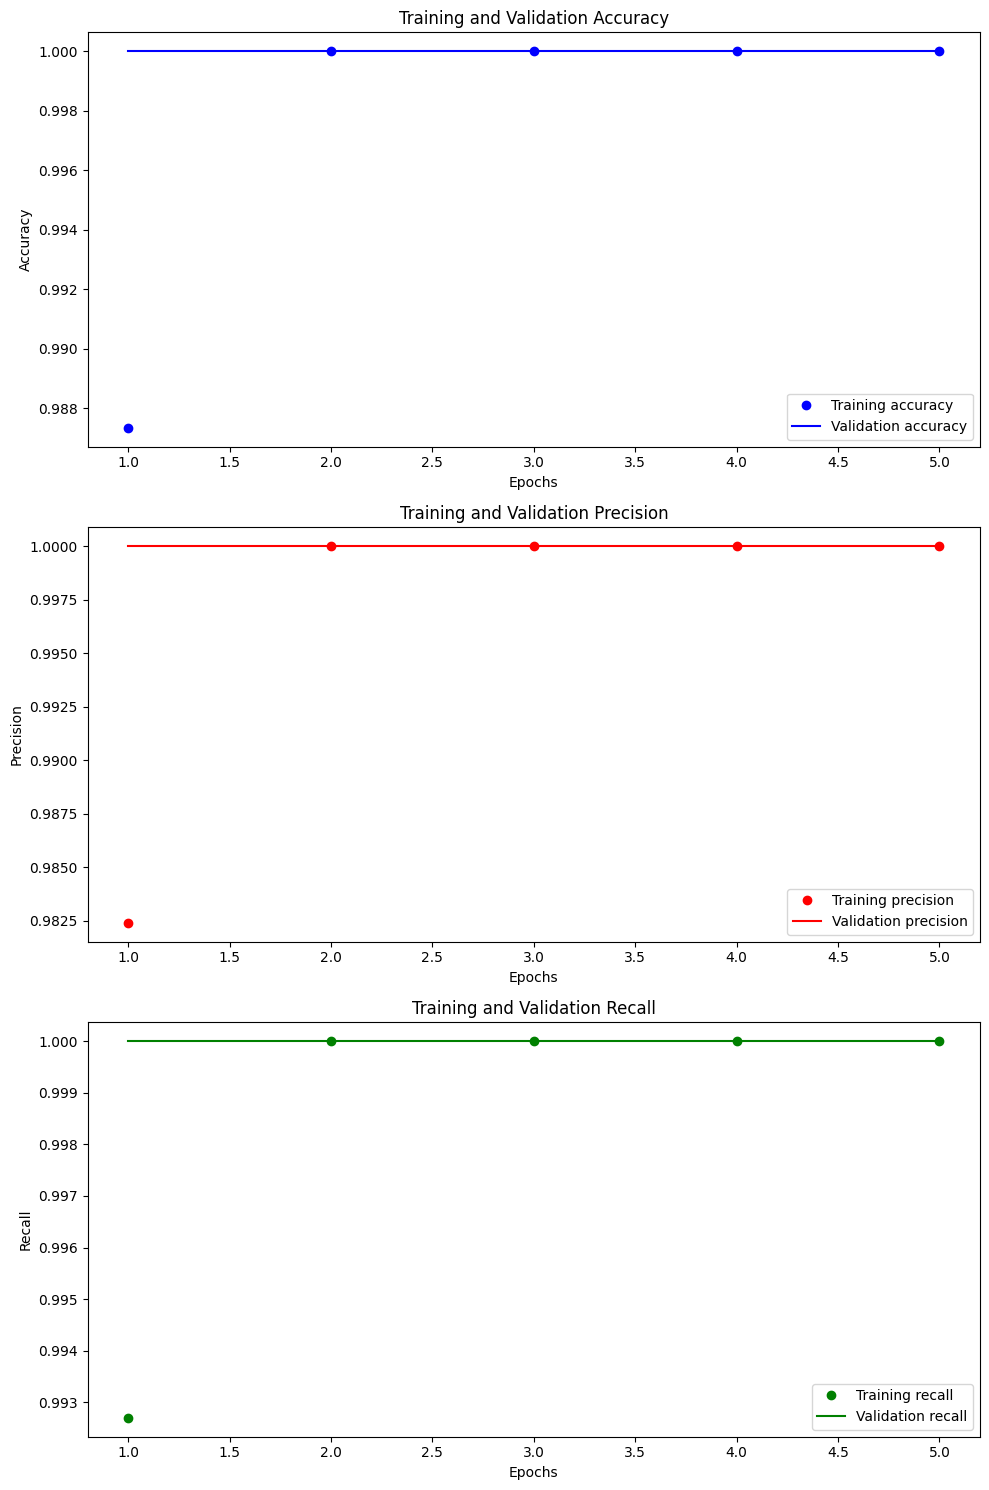

In [ ]:
# Extract training history for accuracy, precision, and recall
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
prec = history.history['precision_5']
val_prec = history.history['val_precision_5']
recall = history.history['recall_5']
val_recall = history.history['val_recall_5']
epochs = range(1, len(acc) + 1)

# Set up the matplotlib figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Plot training and validation accuracy
ax1.plot(epochs, acc, 'bo', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and validation precision
ax2.plot(epochs, prec, 'ro', label='Training precision')
ax2.plot(epochs, val_prec, 'r', label='Validation precision')
ax2.set_title('Training and Validation Precision')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Precision')
ax2.legend()

# Plot training and validation recall
ax3.plot(epochs, recall, 'go', label='Training recall')
ax3.plot(epochs, val_recall, 'g', label='Validation recall')
ax3.set_title('Training and Validation Recall')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Recall')
ax3.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the LSTM model on the test data
loss, accuracy, precision, recall = LSTMmodel.evaluate(X_test, y_test)

# Print the evaluation results
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 1.0000 - loss: 2.2206e-05 - precision_5: 1.0000 - recall_5: 1.0000
Test Loss: 2.07775374292396e-05, Test Accuracy: 1.0, Precision: 1.0, Recall: 1.0


**Confusion Matrix Creation**

163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2629
           1       1.00      1.00      1.00      2575

    accuracy                           1.00      5204
   macro avg       1.00      1.00      1.00      5204
weighted avg       1.00      1.00      1.00      5204



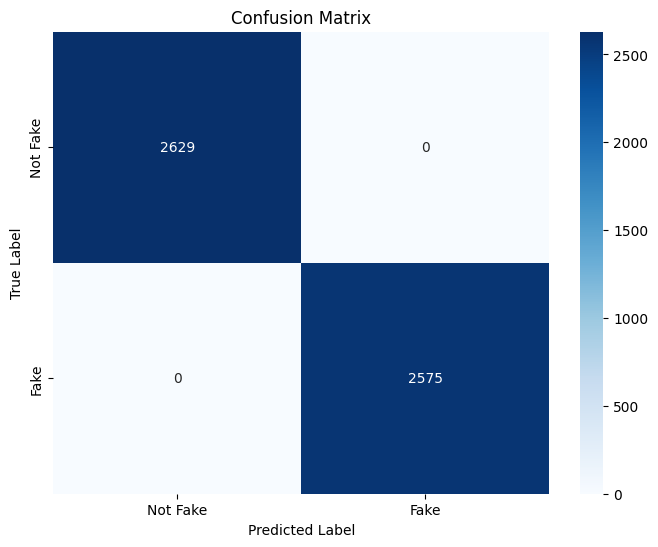

In [ ]:
# Predict the class probabilities and convert to binary class labels
y_pred = LSTMmodel.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_classes)
report = classification_report(y_test, y_pred_classes)

# Output the classification report
print("Classification Report:")
print(report)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Not Fake', 'Fake'], yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Demo

**Import necessary libraries**

In [ ]:
from wordcloud import WordCloud
from collections import Counter

In [ ]:
# Function to preprocess data for LSTM Model
def preprocess_data(text, stars, extreme_sentiment, poor_quality):
    """
    Preprocesses text and numerical data for input into the LSTM model.

    Parameters:
    - text (str): The review text.
    - stars (int): The star rating of the review.
    - extreme_sentiment (int): Binary indicator of extreme sentiment.
    - poor_quality (int): Binary indicator of poor quality.

    Returns:
    - np.array: Preprocessed data sample ready for model input.
    """
    # Tokenize and pad text data
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=100)

    # Scale numerical data
    numerical_features = np.array([[stars, extreme_sentiment, poor_quality]])
    scaled_numerical = scaler.transform(numerical_features)

    # Combine text and numerical data into a single sample
    X = np.hstack((padded_sequence, scaled_numerical))
    return X

In [ ]:
# Demonstration Function for LSTM Model Prediction
def demo(text, stars):
    """
    Predicts whether a review is likely fake based on the provided text and star rating.

    Parameters:
    - text (str): The review text.
    - stars (int): The star rating of the review.

    Returns:
    - str: 'Fake' if the review is predicted to be fake, otherwise 'Not Fake'.
    """
    # Calculate sentiment extremity and quality from the text
    extreme_sentiment = calculate_sentiment_extremity(text, stars)
    poor_quality = check_review_quality(text)

    # Preprocess the data
    X = preprocess_data(text, stars, extreme_sentiment, poor_quality)

    # Make a prediction using the LSTM model
    prediction = lstm_model.predict(X)
    is_fake = 'Fake' if prediction[0][0] >= 0.5 else 'Not Fake'

    return is_fake


In [ ]:
# Review Data Retrieval Function
def ReviewScraper(engine, state):
    """
    Retrieves reviews from the database for a specific state and analyzes them.

    Parameters:
    - engine: The database connection engine.
    - state (str): The state from which to retrieve reviews.

    Returns:
    - pd.DataFrame: A DataFrame containing the reviewed and analyzed data.
    """
    # SQL query to retrieve reviews from a specific state
    query = f"""
    SELECT r.review_id, r.stars, r.text
    FROM reviews r
    JOIN businesses b ON r.business_id = b.business_id
    WHERE b.state = '{state}';
    """
    # Execute the query and load the results into a DataFrame
    df = pd.read_sql(query, engine)

    # Analyze the reviews for sentiment and quality
    df = analyze_reviews(df)

    return df


In [ ]:
# Function to Predict Fake Reviews in Dataset
def predict_fake_reviews(df, model, tokenizer, scaler):
    """
    Predicts which reviews are fake based on text content and numerical features.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the reviews data.
    - model: Trained machine learning model for prediction.
    - tokenizer: Tokenizer object for text data processing.
    - scaler: Scaler object for scaling numerical features.

    Returns:
    - pd.DataFrame: DataFrame containing the reviews predicted as fake.
    """
    # Preprocess text data
    sequences = tokenizer.texts_to_sequences(df['text'])
    x_text = pad_sequences(sequences, maxlen=100)

    # Scale numerical data
    x_numerical = scaler.transform(df[['stars', 'extreme_sentiment', 'poor_quality']])

    # Combine text and numerical data
    x = np.hstack((x_text, x_numerical))

    # Make predictions on the combined data
    predictions = model.predict(x)
    df['prediction'] = (predictions > 0.5).astype(int)

    # Filter for reviews predicted as fake
    fake_reviews = df[df['prediction'] == 1]

    return fake_reviews[['review_id', 'text']]

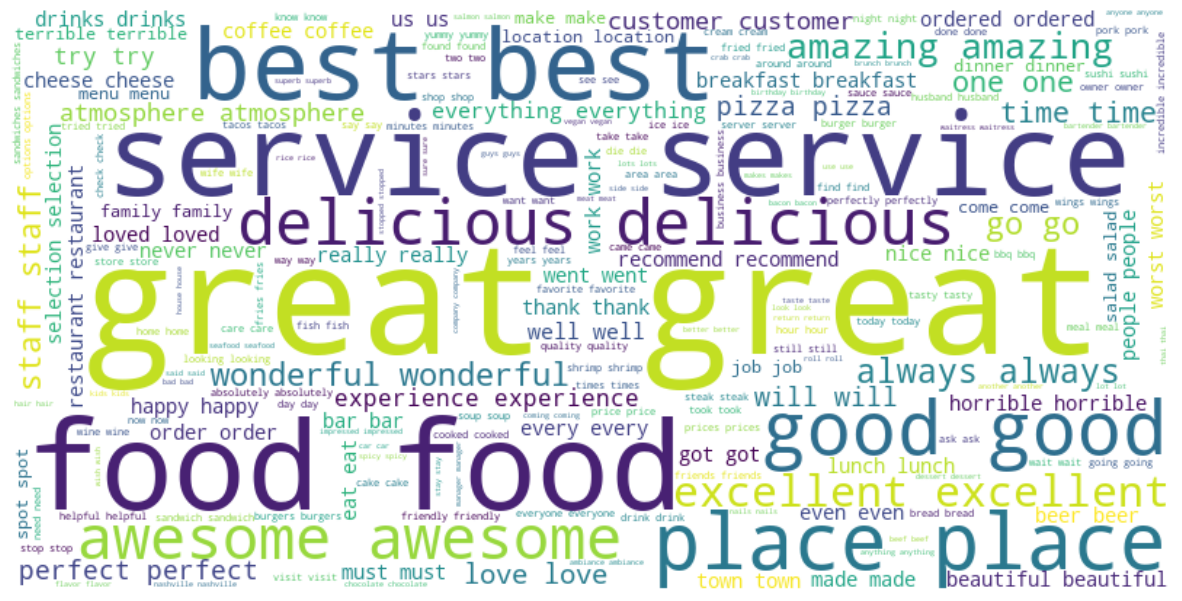

In [ ]:
# Function to Generate Word Cloud for Fake Reviews
def generate_word_cloud(dataframe):
    """
    Generates a word cloud from the text of reviews marked as likely fake.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing reviews data.
    """
    # Filter for fake reviews
    fake_reviews = dataframe[dataframe['likely_fake'] == 1]

    # Tokenization (assuming 'tokenizer' is already fitted)
    sequences = tokenizer.texts_to_sequences(fake_reviews['text'])

    # Flatten the list of sequences to count word frequencies
    word_counts = Counter(word for seq in sequences for word in seq)

    # Mapping index to word
    index_word = {v: k for k, v in tokenizer.word_index.items()}

    # Create a single string with all words
    words_string = ' '.join(index_word.get(idx, '?') for idx, count in word_counts.items() for _ in range(count))

    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_string)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # No axis for a cleaner look
    plt.show()

generate_word_cloud(meta_analyzed_data)

In [ ]:
# Prompt user for a review text and display the entered text
user_input = input("Enter a review text: ")
print(user_input)

I loved the experience at this restaurant. So wonderful and excellent. The food was delclious, drink amazing, I had the best time of my life. Staff was the worst tho. Still I would recommend it to everyone I know. Can't wait to eat here again. 


In [ ]:
# Predict the authenticity of the entered review and display the result
result = predict_review(user_input, stars=5)
print("The review is predicted as:", result)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
The review is predicted as: Not Fake


In [ ]:
# Prompt user for another review text (example pre-filled) and display the entered text
user_input = input("Enter a review text: ")
print(user_input)

I love this amazing place and excellent food.


In [ ]:
# Predict the authenticity of the entered review and display the result
result = predict_review(user_input, stars=5)
print("The review is predicted as:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
The review is predicted as: Not Fake


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Prompt user for a review text and display the entered text
user_input = input("Enter a review text: ")
print(user_input)

Great pizza! Great staff! I love this place's drinks and food so much. Absolutely perfect.


In [ ]:
# Predict the authenticity of the entered review and display the result
result = predict_review(user_input, stars=5)
print("The review is predicted as:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
The review is predicted as: Fake


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


* Try it on the Illnois Dataset

In [ ]:
# Scrape review data for the state of Illinois (IL) and display the first few rows
IL_data = ReviewScraper(engine,'IL')
IL_data.head()

,review_id,stars,text,extreme_sentiment,poor_quality,likely_fake
0,N-73-mYjkUbcPwOvIT_MhA,4.0,They had a rough start but we really enjoy eat...,0,1,0
1,ne0H_BI_0eqXPjqESLbqjg,5.0,This is probably the best restaurant I have ev...,0,1,0
2,8bZmzYSB_nRPepV5xZtOfg,4.0,Italian food is one of my favorite types of fo...,0,1,0
3,2dazjom3Hz2cmkHw801xOA,4.0,I Love Gia's pizza and will officially say tha...,0,1,0
4,GyeeOWfs2y7lhrTNRPhpNA,5.0,Not only is this the best Thai food you will f...,0,1,0


In [ ]:
# Predict fake reviews using the specified model, tokenizer, and scaler on Illinois dataset
predicted_fakes = predict_fake_reviews(IL_data, model, tokenizer, scaler)

# Configure pandas to display the full text of reviews without truncation
pd.set_option('display.max_colwidth', None)

# Print the DataFrame containing predicted fake reviews
print(predicted_fakes)

# Reset the pandas display option to default setting for column width
pd.reset_option('display.max_colwidth')

1620/1620 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step
                    review_id  \
58     NWwUYu43-FpiBe9dQz1ZSA   
101    djI4X0HitqZnKKhejVWGgA   
217    lH5j4wZ0mJ2yg7bd2oItRQ   
422    fOrQ6v4Jsw8uicvHecHumw   
499    svrHQVsfmpSOeFOfqOeBgg   
...                       ...   
51550  B33Yi2piKtc2b9Wgro_Q_Q   
51551  T6yA7TAzzp9hGN9i-pGRYg   
51621  9rkcRGBSnv_nMSrQlYp_sQ   
51716  pgWl3AyJVvbTMvRajXbnnQ   
51816  M8U9TdbCPaDDQ-QtyrQQBw   

                                                                                                                                                                                 text  
58                                                                 Had a wonderful experience with JT and Ashley Furniture store!! He was helpful even when I had to change my order.  
101    We had my friends bridal shower here and it was so beautiful! The staff was so friendly and helpful! Everyone at the Wine Tap was AMAZING!! Of course, food was delicious too!  
217   